In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rolling_nm import make_rolling_footprints
from rubin_sim.scheduler.modelObservatory import Model_observatory
from rubin_sim.scheduler.utils import standard_goals, Footprint
from rubin_sim.utils import raDec2Hpid

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.metricBundles as metricBundles

In [2]:

nside = 32
observatory = Model_observatory(nside=nside)
conditions = observatory.return_conditions()
sun_ra_0 = conditions.sunRA  # radians
scale = 0.9
nslice = 2
footprints_rolling2 = make_rolling_footprints(mjd_start=conditions.mjd_start,
                                         sun_RA_start=conditions.sun_RA_start, nslice=nslice, scale=scale,
                                         nside=nside)
nslice = 3
footprints_rolling3 = make_rolling_footprints(mjd_start=conditions.mjd_start,
                                         sun_RA_start=conditions.sun_RA_start, nslice=nslice, scale=scale,
                                         nside=nside)

/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/SkyModelPre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn('Requested MJD between sunrise and sunset, returning closest maps')


In [3]:
observatory = Model_observatory(nside=nside)
footprints_hp = standard_goals(nside=nside)
conditions = observatory.return_conditions()
footprints = Footprint(conditions.mjd_start, sun_RA_start=conditions.sun_RA_start, nside=nside)
for i, key in enumerate(footprints_hp):
    footprints.footprints[i, :] = footprints_hp[key]

In [4]:
mjds = np.arange(conditions.mjd_start,conditions.mjd_start+365.25*10,1)

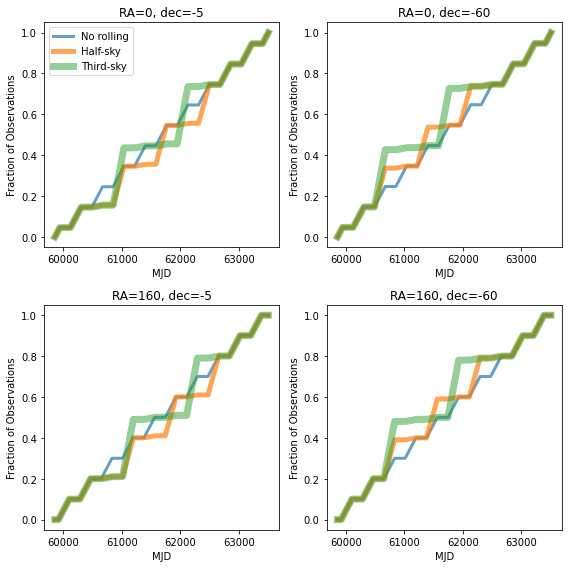

In [5]:
ras = [0, 0, 160, 160]
decs = [-5, -60, -5, -60]


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))
axes = [ax1, ax2, ax3, ax4]
k=0
for ra, dec, ax in zip(ras,decs, axes):
    i = raDec2Hpid(nside, ra, dec)
    fp1 = []
    fp_roll = []
    fp_roll3 = []
    for mjd in mjds:
        ack = footprints(mjd, norm=False)['r']
        fp1.append(ack[i])
        ack = footprints_rolling2(mjd, norm=False)['r']
        fp_roll.append(ack[i])
        ack = footprints_rolling3(mjd, norm=False)['r']
        fp_roll3.append(ack[i])

    fp1=np.array(fp1)
    fp_roll = np.array(fp_roll)
    fp_roll3 = np.array(fp_roll3)

    ax.plot(mjds, fp1/10, label='No rolling', linewidth=3, alpha=0.7)
    ax.plot(mjds, fp_roll/10, label='Half-sky', linewidth=5, alpha=0.7)
    ax.plot(mjds, fp_roll3/10, label='Third-sky', linewidth=7, alpha=0.5)
    ax.set_ylabel('Fraction of Observations')
    ax.set_xlabel('MJD')
    if k == 0:
        ax.legend()
    ax.set_title('RA=%i, dec=%i' % (ra, dec))
    k+=1
fig.tight_layout()
plt.savefig('footprint_ideal.pdf')

In [6]:
dbFile = 'baseline_nexp2_v1.7.1_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
# Set the output directory
outDir = 'temp'
resultsDb = db.ResultsDb(outDir)

In [7]:
bundleList = []

# Grab everything
sql = ''

ra = np.array([ 0.])
dec = np.array([ -20.])
# Look at just one point on the sky
slicer = slicers.UserPointsSlicer(ra, dec)
# Pull out this information for visits that overlap that point
metric = metrics.PassMetric(cols=['observationStartMJD', 'fiveSigmaDepth', 'filter', 'note'])
plotDict={}
summaryStats = []
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             plotDict=plotDict,
                                             summaryMetrics=summaryStats))
bg = metricBundles.MetricBundleGroup(bundleList, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database SummaryAllProps with no constraint for columns ['fieldRA', 'filter', 'note', 'observationStartMJD', 'fiveSigmaDepth', 'fieldDec'].
Found 2044984 visits
Running:  ['opsim_Pass_observationStartMJD_fiveSigmaDepth_filter_note_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


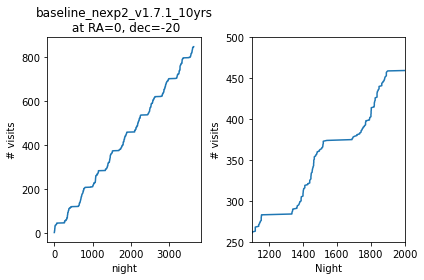

In [8]:
bundleList[0].metricValues[0].sort(order='observationStartMJD')
yval = np.arange(1,bundleList[0].metricValues[0].size+1, 1)
xval = bundleList[0].metricValues[0]['observationStartMJD']
xval -= xval.min()

fig, ax = plt.subplots(1,2)

ax[0].plot(xval,yval)
ax[0].set_xlabel('night')
ax[0].set_ylabel('# visits')
ax[0].set_title('%s\n at RA=%i, dec=%i' %(runName, ra, dec))


ax[1].plot(xval,yval)
ax[1].set_xlabel('Night')
ax[1].set_ylabel('# visits')
#ax[1].set_title('%s\n at RA=%i, dec=%i' %(runName, ra, dec))
ax[1].set_xlim([365.25*3,2000])
ax[1].set_ylim([250.,500])
fig.tight_layout()
fig.savefig('actual_footprint.pdf')